In [1]:
import pandas as pd
import numpy as np

test = pd.read_csv('test.csv')
autoru = pd.read_csv('autoru_cleared.csv')
%matplotlib inline

In [2]:
color_dict = {
    'чёрный': 'black',
    'белый': 'white',
    'серый': 'gray',
    'серебристый': 'silver',
    'синий': 'blue',
    'коричневый': 'gray',
    'красный': 'red',
    'зелёный': 'green',
    'бежевый': 'brown',
    'голубой': 'blue',
    'пурпурный': 'red',
    'золотистый': 'other',
    'фиолетовый': 'violet',
    'жёлтый': 'yellow',
    'оранжевый': 'orange',
    'розовый': 'other',
    'other': 'other'
}
fuel_dict = {
    'gasoline': 'бензин',
    'diesel': 'дизель',
    'gas': 'газ',
    'hybrid-petrol': 'гибрид',
    'electric': 'электро',
    'hybrid-diesel': 'гибрид'
}
body_dict = {
    'внедорожник 5 дв.': 'suv',
    'седан': 'sedan',
    'лифтбек': 'liftback',
    'хэтчбек 5 дв.': 'hatchback',
    'универсал 5 дв.': 'universal',
    'универсал 3 дв.': 'universal',
    'минивэн': 'minivan',
    'купе': 'coupe',
    'компактвэн': 'minivan',
    'хэтчбек 3 дв.': 'hatchback',
    'пикап двойная кабина': 'pickup',
    'внедорожник 3 дв.': 'suv',
    'купе-хардтоп': 'coupe',
    'кабриолет': 'cabriolet',
    'фургон': 'van',
    'родстер': 'coupe',
    'микровэн': 'minivan',
    'седан-хардтоп': 'sedan',
    'пикап одинарная кабина': 'pickup',
    'пикап полуторная кабина': 'pickup',
    'внедорожник открытый': 'suv',
    'лимузин': 'limousine',
    'тарга': 'cabriolet',
    'седан 2 дв.': 'coupe',
    'фастбек': 'hatchback',
    'хэтчбек 4 дв.': 'hatchback',
    'фаэтон': 'cabriolet'
    
}
transmission_dict = {
    'автоматическая': 'automatic',
    'автомат': 'automatic',
    'механическая': 'mechanical',
    'механика': 'mechanical',
    'роботизированная': 'robot',
    'робот': 'robot',
    'вариатор': 'variator'
}
drivetrain_dict = {
    'полный': 'all',
    'передний': 'front',
    'задний': 'rear'
}

In [3]:
def clear_eng_power(hp):
    capacity = str(hp).split()[0]
    if capacity == 'undefined':
        return 2.0
    return float(capacity)

def eval_features(feature_string):
    feature_count = 0
    if len(feature_string) > 5:
        for i in eval(feature_string[2:-2]):
            feature_count += len(i['values'])
        return feature_count
    else:
        return 0

test['color'] = test['color'].apply(lambda x:color_dict[x])
test['vehicleTransmission'] = test['vehicleTransmission'].apply(lambda x:transmission_dict[x])
test['Привод'] = test['Привод'].apply(lambda x:drivetrain_dict[x])
test['productionDate'] = test['productionDate'].apply(lambda x:int(x))
test['mileage'] = test['mileage'].apply(lambda x:int(x))
test['enginePower'] = test['enginePower'].apply(clear_eng_power)
test['engineDisplacement'] = test['engineDisplacement'].apply(clear_eng_power)
test['features_count'] = (test['Комплектация'].apply(eval_features)//8).apply(lambda x: x if x<10 else 9)

test = test.rename(columns={'bodyType': 'body_type',
                            'brand': 'manufacturer_name',
                            'mileage': 'odometer_value',
                            'vehicleTransmission': 'transmission',
                            'productionDate': 'year_produced',
                            'fuelType': 'engine_fuel',
                            'engineDisplacement': 'engine_capacity',
                            'enginePower': 'engine_power',
                            'Привод': 'drivetrain'
})
test['year_produced'] = test['year_produced'] - (1938+39)
autoru['year_produced'] = autoru['year_produced'] - 39

In [4]:
autoru = autoru[autoru['manufacturer_name'].isin(test['manufacturer_name'])]

autoru['power_per_volume'] = autoru['engine_power']/autoru['engine_capacity']
test['power_per_volume'] = test['engine_power']/test['engine_capacity']

autoru = autoru[autoru['engine_capacity'] < 7]
autoru = autoru[autoru['odometer_value'] > 0]

autoru['model_name'] = autoru['Name'].str.findall(pat='\d\S+[dixs]').apply(lambda x: ''.join(x[0]) if len(x)>0 else 'other')
test['model_name'] = test['name'].str.findall(pat='\d\S+[dixs]').apply(lambda x: ''.join(x[0]) if len(x)>0 else 'other')

autoru['xdrive'] = autoru['Name'].str.contains(pat='xDrive')
test['xdrive'] = test['name'].str.contains(pat='xDrive')

In [5]:
def calculate_tax(power):
    tax_dict ={
        '100': 2.5,
        '150': 3.5,
        '200': 5,
        '250': 7.5,
        'max': 15
    }
    key = ''
    
    if power <= 100:
        key = '100'
    elif power <= 150:
        key = '150'
    elif power <= 200:
        key = '200'
    elif power <= 250:
        key = '250'
    else:
        key = 'max'
    
    return power*tax_dict[key]
                    
        
autoru['tax'] = autoru['engine_power'].apply(calculate_tax)
test['tax'] = test['engine_power'].apply(calculate_tax)

In [6]:
autoru['engine_capacity'] = (autoru['engine_capacity']*10).astype('int32')
test['engine_capacity'] = (test['engine_capacity']*10).astype('int32')

autoru['odometer_value'] = (autoru['odometer_value']//10000).astype('int32')
test['odometer_value'] = (test['odometer_value']//10000).astype('int32')

autoru['engine_power'] = (autoru['engine_power']).astype('int32')
test['engine_power'] = (test['engine_power']).astype('int32')

In [7]:
import numpy as np

cat_features = ['body_type',#0
                'transmission',#1
                'engine_fuel',#2
                'color',#3
                'drivetrain',#4
                'model_name',#5
                'xdrive',#6
                'year_produced',#7


]


num_features = ['engine_capacity', #8
                'engine_power',#9
                'odometer_value',#10
                'power_per_volume',#11
                'tax'#12
    
]

autoru = autoru[cat_features+num_features+['price']]
test_original = test.copy()
test = test[cat_features+num_features]

In [8]:
for feature in cat_features:
    values_to_drop = set(autoru[feature].unique())-set(test[feature].unique())
    autoru = autoru[~autoru[feature].isin(values_to_drop)]
    autoru[feature] = autoru[feature].astype('category')
    test[feature] = test[feature].astype('category')
len(autoru)

27814

In [9]:
odometer_handicup = test_original['ПТС'].apply(lambda x: 0 if x=='Оригинал' else 3)
test['odometer_value'] += odometer_handicup

In [10]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))


X = autoru.drop(['price'], axis=1)
y = (autoru['price']**0.5)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)

In [ ]:
ITERATIONS   = 1000
LR           = 0.12
CAT_FEATURES = [0,1,2,3,4,5,6,7]

from catboost import CatBoostRegressor
model = CatBoostRegressor(iterations = ITERATIONS,
                          learning_rate = LR,
                          eval_metric = 'MAPE',
                          custom_metric = ['R2', 'MAE'],
                          early_stopping_rounds = 500
                         )

model.fit(X, y,
            cat_features=CAT_FEATURES,
            eval_set=(X_test, y_test),
            verbose_eval=500,
            use_best_model=True,
            plot=True
            )
print(mape(autoru['price'], model.predict(X)**2))
print(mean_absolute_error(autoru['price'], model.predict(X)**2))

pred = model.predict(test)
sample_submission = pd.DataFrame()
sample_submission['price'] = pred
sample_submission['price'] = (sample_submission['price']**2) #REVERT SQRT
sample_submission = sample_submission.reset_index().rename(columns={'index': 'id'})
sample_submission.to_csv(f'submission_v1.csv', index=False)

In [ ]:
CAT_FEATURES = [0,1,2,3,4,5,6,7,8]

1 Fold Test MAPE: 0.0527
2 Fold Test MAPE: 0.0538
3 Fold Test MAPE: 0.0521
4 Fold Test MAPE: 0.0536
5 Fold Test MAPE: 0.0524
6 Fold Test MAPE: 0.0539
7 Fold Test MAPE: 0.0505
Mean Score: 0.0527
Std Score: 0.0011
Max Score: 0.0539
Min Score: 0.0505


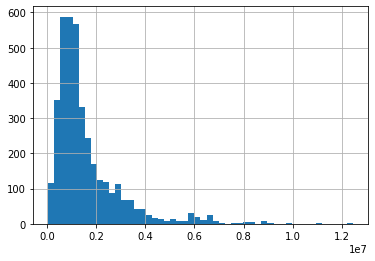

In [13]:
N_FOLDS      = 7
ITERATIONS   = 1200
LR           = 0.1
CAT_FEATURES = [0,1,2,3,4,5,6,7]

from catboost import CatBoostRegressor
from sklearn.model_selection import KFold

def cat_model(y_train, X_train, X_test, y_test):
    model = CatBoostRegressor(iterations = ITERATIONS,
                              learning_rate = LR,
                              eval_metric='MAPE',
                             )
    model.fit(X_train, y_train,
              cat_features=CAT_FEATURES,
              eval_set=(X_test, y_test),
              verbose=False,
              use_best_model=True,
              plot=False
             )    
    return(model)

submissions = pd.DataFrame()
score_ls = []
splits = list(KFold(n_splits=N_FOLDS, shuffle=True).split(X, y))


X = autoru.drop(['price'], axis=1)
y = (autoru['price']**0.5).values
for idx, (train_idx, test_idx) in enumerate(splits):
    
    X_train, y_train, X_test, y_test = X.iloc[train_idx], y[train_idx], X.iloc[test_idx], y[test_idx]
    model = cat_model(y_train, X_train, X_test, y_test)
    
    test_predict = model.predict(X_test)
    test_score = mape(y_test, test_predict)
    score_ls.append(test_score)
    submissions[f'sub_{idx+1}'] = model.predict(test)
    
    print(f"{idx+1} Fold Test MAPE: {mape(y_test, test_predict):0.4f}")

print(f'Mean Score: {(np.mean(score_ls)):0.4f}')
print(f'Std Score: {(np.std(score_ls)):0.4f}')
print(f'Max Score: {(np.max(score_ls)):0.4f}')
print(f'Min Score: {(np.min(score_ls)):0.4f}')

sample_submission = pd.DataFrame()
submissions['blend'] = (submissions.sum(axis=1))/len(submissions.columns)
sample_submission['price'] = (submissions['blend'].values)**2 #REVERT SQRT
sample_submission = sample_submission.reset_index().rename(columns={'index': 'id'})
sample_submission.to_csv('submission_blend_v1.csv', index=False)
sample_submission['price'].hist(bins=50)